In [1]:
# %matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
import os 
DATA_DIR = "/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullresolution"


demo_dirs = os.listdir(DATA_DIR)
# filter out directories that are not demos
demo_dirs = [d for d in demo_dirs if os.path.isdir(os.path.join(DATA_DIR, d))]
# sort by name
demo_dirs.sort()
print(f"Found {len(demo_dirs)} demonstrations")


# ðemo dir 
#  back_camera
# data.mp4

video_paths = [os.path.join(DATA_DIR, demo_dir, "back_camera", "data.mp4") for demo_dir in demo_dirs]
print(video_paths)

Found 31 demonstrations
['/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullresolution/demo_0/back_camera/data.mp4', '/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullresolution/demo_1/back_camera/data.mp4', '/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullresolution/demo_10/back_camera/data.mp4', '/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullresolution/demo_11/back_camera/data.mp4', '/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullresolution/demo_12/back_camera/data.mp4', '/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullresolution/demo_13/back_camera/data.mp4', '/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullresolution/demo_14/back_camera/data.mp4', '/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullresolution/demo_15/back_camera/data.mp4', '/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullre

In [3]:
# get initial frames for each video

initial_frames = []
for video_path in video_paths:
    video = cv2.VideoCapture(video_path)
    ret, frame = video.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    initial_frames.append(frame)

# save the initial frames
initial_frames = np.array(initial_frames)

In [4]:
# # instead, now get all frames of a single video
url = "/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullresolution/demo_1/back_camera/data.mp4"

import imageio.v3 as iio
frames = iio.imread(url, plugin="FFMPEG")  # plugin="pyav"
# frames = frames[-1100:-800]
print(len(frames))
initial_frames = frames[::40]
print(len(initial_frames))

855
22


In [5]:
from transformers import AutoModelForZeroShotObjectDetection, AutoProcessor
model_id =  "IDEA-Research/grounding-dino-tiny"
device = "cuda"
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)
processor = AutoProcessor.from_pretrained(model_id)









Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
text_labels = ["pen", "box"]


In [7]:
import torch
color_list = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255), (255, 255, 255), (0, 0, 0)]


img = initial_frames[0]




def get_bounding_boxes(img, text_labels):
    # https://github.com/huggingface/transformers/blob/main/src/transformers/models/grounding_dino/processing_grounding_dino.py
    
    text_labels = [text_labels]
    inputs = processor(text=text_labels, images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    results = processor.post_process_grounded_object_detection(outputs, inputs.input_ids,threshold=0.26, target_sizes=[img.shape[:2]])
    return results[0]






results = get_bounding_boxes(img, text_labels)



/home/tlips/Code/few-shot-keypoints/.venv/lib/python3.12/site-packages/transformers/models/grounding_dino/processing_grounding_dino.py:94: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)


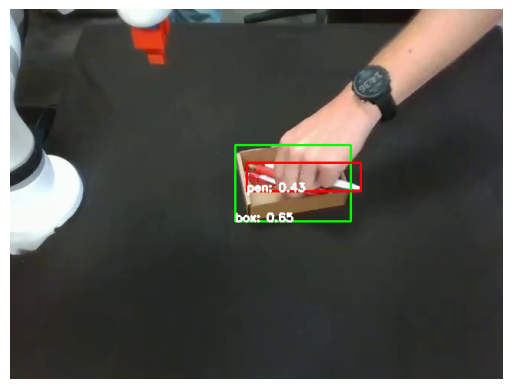

In [8]:
def visualize_boxes_on_image(img, results, text_labels):
    annotated_img = img.copy()
    # check if any annotations
    if len(results['boxes']) is None or len(results['boxes']) == 0:
        return annotated_img
    for box, label, score in zip(results['boxes'], results['labels'], results['scores']):
    
        x1, y1, x2, y2 = box
        x1 = int(x1)
        y1 = int(y1)
        x2 = int(x2)
        y2 = int(y2)
        label_idx = text_labels.index(label)
        annotated_img = cv2.rectangle(annotated_img, (x1, y1), (x2, y2), color_list[label_idx], 2)
        annotated_img = cv2.putText(annotated_img, f"{label}: {score:.2f}", (x1, y2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    return annotated_img


annotated_img = visualize_boxes_on_image(img, results, text_labels)
plt.imshow(annotated_img)
plt.axis("off")
plt.show()

In [11]:
# run the model on all frames and store the results in a list 

initial_frame_results  =  []
times = []
import time 
for frame in initial_frames:
    start_time = time.time()
    # resize frame to 256x256
    # frame = cv2.resize(frame, (256, 256))
    results = get_bounding_boxes(frame, text_labels)
    end_time = time.time()
    times.append(end_time - start_time)
    initial_frame_results.append(results)


print(f"Average time per frame: {sum(times) / len(times)}")



Average time per frame: 0.09032600576227362


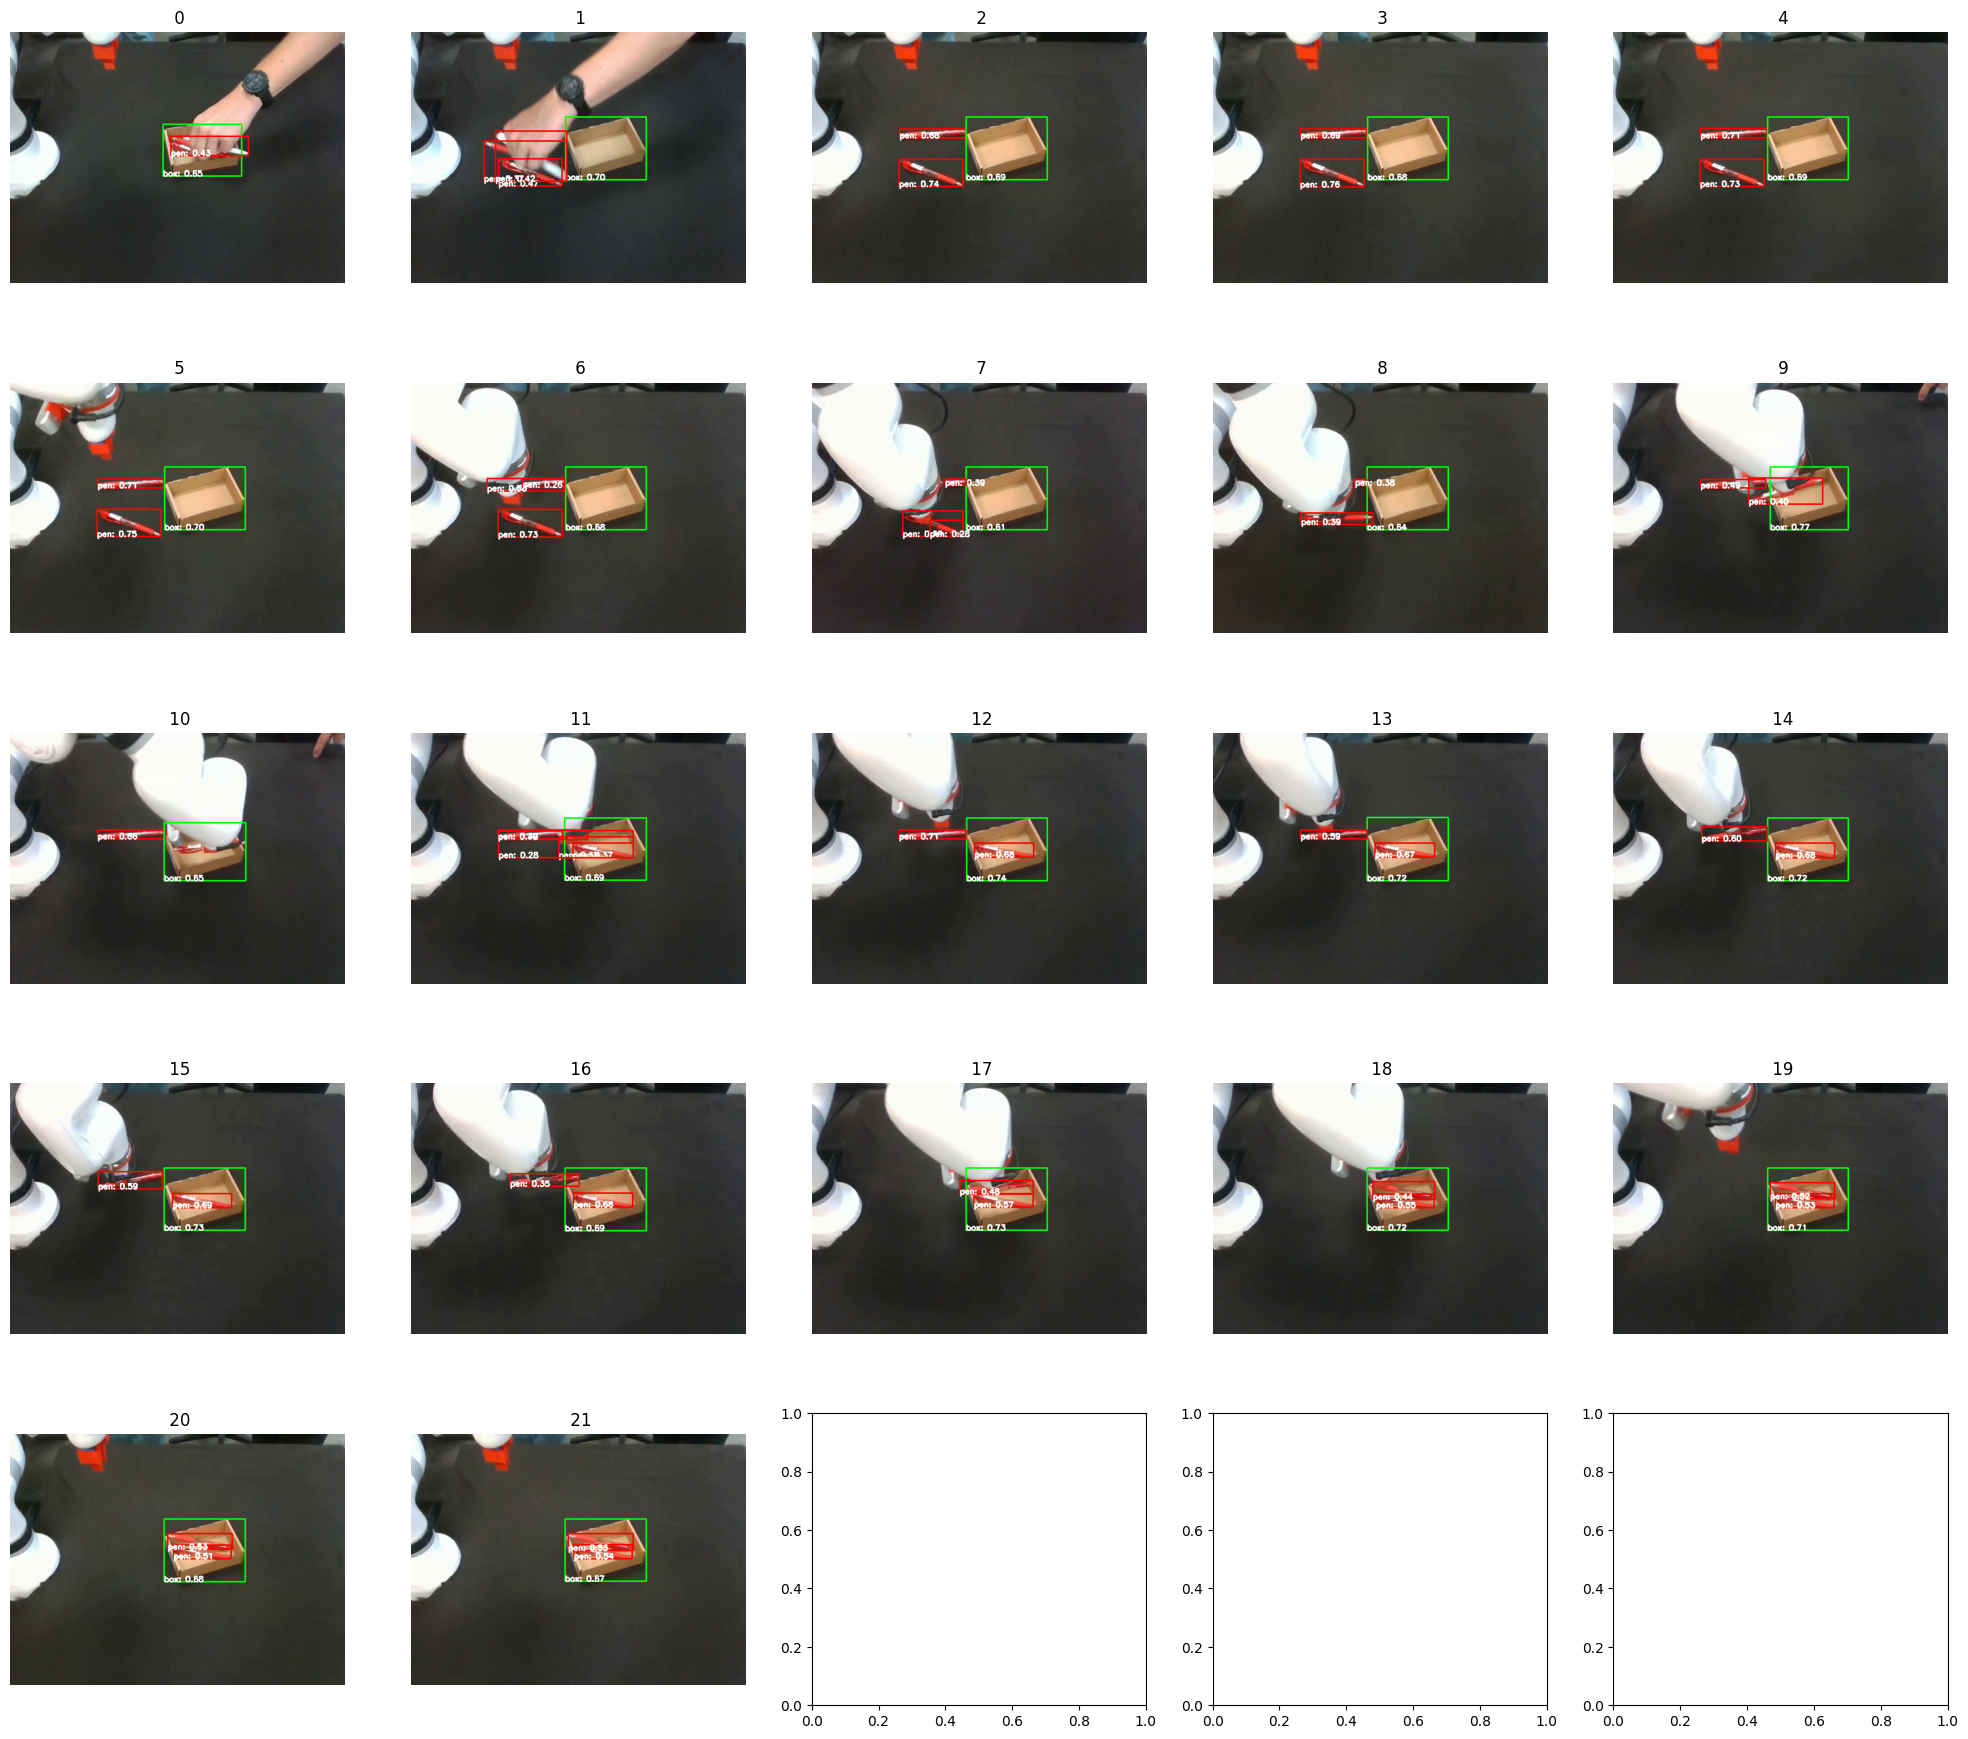

In [10]:
# visualize in a single figure with 5 by len(initial_frames) // 5 + 1 grid

fig, axs = plt.subplots(len(initial_frames) // 5 + 1, 5, figsize=(25, 5 * len(initial_frames) // 5))
for i, frame in enumerate(initial_frames):
    # frame = cv2.resize(frame, (256, 256))
    img = visualize_boxes_on_image(frame, initial_frame_results[i], text_labels)
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].axis("off")
    axs[i // 5, i % 5].set_title(f" {i}")
plt.show()